In [57]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

In [49]:
# Cargar data enriquecida
df = pd.read_csv("../data/aptos_bogota_enriched.csv")
df.head()

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,latitud,...,accommodation_2000,parks_and_recreation_2000,infrastructure_services_2000,cultural_amenities_2000,catastral,comercial,estrato_calculado,upz_calculada,barrio_calculado,localidad_calculada
0,339000000.0,76.0,3.0,2.0,300000.0,1.0,BRITALIA,3.0,ENTRE 10 Y 20 ANOS,4.746592,...,23,19,87,5,2.772455e+06,2.772455e+06,6,USAQUEN,SANTA ANA ORIENTAL,USAQUÉN
1,223000000.0,63.0,3.0,2.0,NaN,0.0,SAN CRISTOBAL NORTE,3.0,MAS DE 20 ANOS,4.730111,...,15,38,74,2,2.317592e+06,2.317592e+06,5,USAQUEN,DELICIAS DEL CARMEN,USAQUÉN
2,440898168.0,54.0,3.0,2.0,305000.0,0.0,LA SABANA,3.0,ENTRE 0 Y 5 ANOS,4.607378,...,3,30,76,1,1.242259e+06,1.242259e+06,6,LA FLORESTA,S.C. CLUB DE LOS LAGARTOS,SUBA
3,158000000.0,43.0,2.0,2.0,106600.0,0.0,TIBABUYES,2.0,ENTRE 10 Y 20 ANOS,4.740109,...,1,22,71,0,3.832116e+06,3.832116e+06,6,NIZA,NIZA SUBA - EL BALCÓN DE LINDARAJA,SUBA
4,222800000.0,48.0,3.0,2.0,151000.0,0.0,VERBENAL,3.0,MAS DE 20 ANOS,4.763900,...,14,29,70,2,1.381715e+06,1.381715e+06,4,GRANJAS DE TECHO,URB. PRADO GRANDE,FONTIBÓN


In [51]:
df = df.drop("estrato", axis=1).rename(columns={"estrato_calculado": "estrato", "barrio_calculado": "barrio", "upz_calculada": "upz"})
df[df["barrio"].isnull()].shape
df = df[~df['barrio'].isnull()].reset_index(drop=True)
df[df["barrio"].isnull()].shape

(0, 62)

In [52]:
def imputar_por_barrio(df, columna, metodo='media'):
    if metodo == 'media':
        imputacion = df.groupby('barrio')[columna].transform('mean')
    elif metodo == 'moda':
        imputacion = df.groupby('barrio')[columna].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    else:
        raise ValueError("Método no soportado.")
    
    df[columna] = df[columna].fillna(imputacion)
    return df

In [53]:
for col, metodo in [
    ('administracion', 'media'),
    ('estado', 'moda'),
    ('upz', 'moda'),
    ('catastral', 'media'),
    ('comercial', 'media'),
    ('antiguedad', 'moda')
]:
    df = imputar_por_barrio(df, col, metodo)

In [ ]:
ignore_cols = ['precio_venta', 'sector', 'localidad_calculada']
train_df, holdout_df = train_test_split(df, test_size=0.2, random_state=42)


target = 'precio_venta'
features = [col for col in train_df.columns if col not in ignore_cols]

In [55]:
X_train = train_df[features]
y_train_log = np.log(train_df[target])

numerical_features = train_df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df[features].select_dtypes(include=['object']).columns.tolist()


In [56]:
# crear transformador para log(area)
def log_transform(x):
    x = np.where(x <= 0, np.nan, x)  # evitar log(0)
    return np.log(x)


In [58]:
log_area_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(log_transform, validate=False))
])

num_cols_sin_area = [col for col in numerical_features if col != 'area']

numeric_transformer = ColumnTransformer(
    transformers=[
        ('log_area', log_area_transformer, ['area']),
        ('num', SimpleImputer(strategy='median'), num_cols_sin_area)
    ]
)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model = XGBRegressor(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    objective='reg:squarederror', random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [59]:
pipeline.fit(X_train, y_train_log)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Feature importance

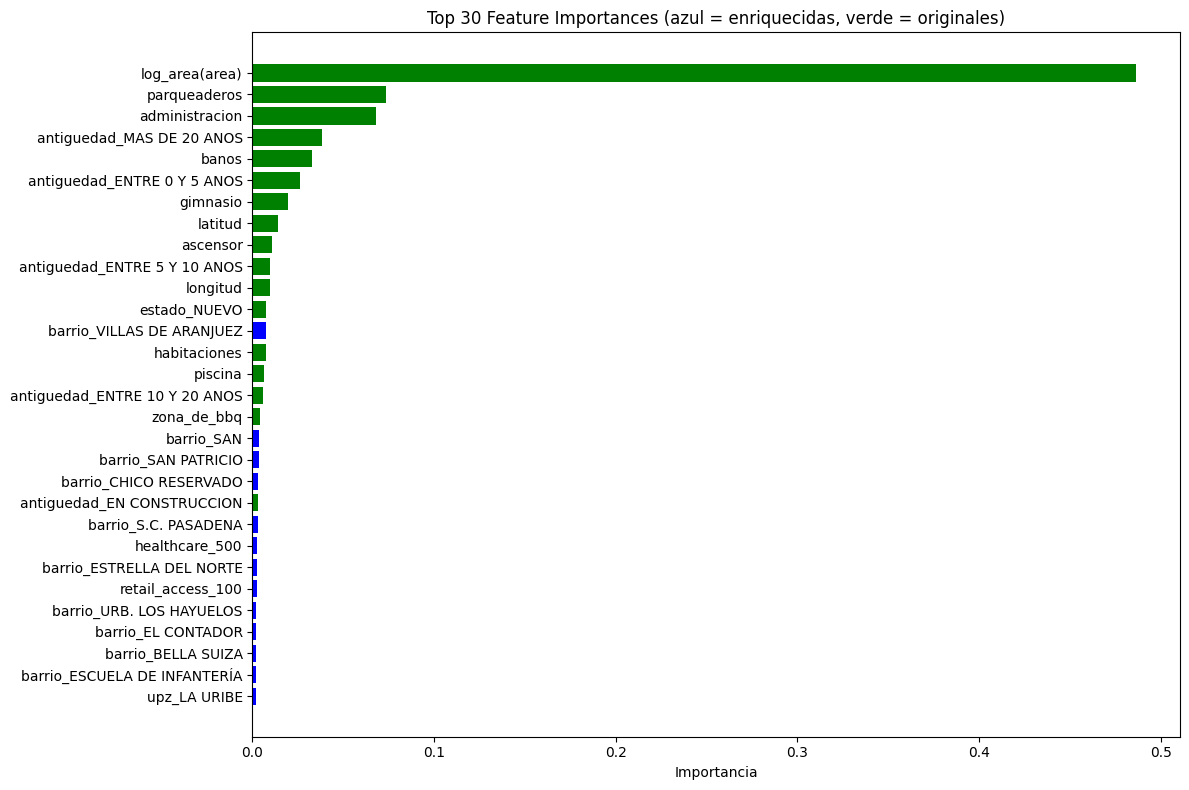


Top 30 variables más importantes:
log_area(area)                                     0.4863 (original)
parqueaderos                                       0.0735 (original)
administracion                                     0.0678 (original)
antiguedad_MAS DE 20 ANOS                          0.0384 (original)
banos                                              0.0328 (original)
antiguedad_ENTRE 0 Y 5 ANOS                        0.0259 (original)
gimnasio                                           0.0195 (original)
latitud                                            0.0142 (original)
ascensor                                           0.0108 (original)
antiguedad_ENTRE 5 Y 10 ANOS                       0.0099 (original)
longitud                                           0.0097 (original)
estado_NUEVO                                       0.0074 (original)
barrio_VILLAS DE ARANJUEZ                          0.0074 (enriquecida)
habitaciones                                       0.0073 (origin

In [62]:
variables_aumentadas = [
    'education_100', 'healthcare_100', 'retail_access_100', 'dining_and_entertainment_100', 
    'accommodation_100', 'parks_and_recreation_100', 'infrastructure_services_100', 'cultural_amenities_100', 
    'education_300', 'healthcare_300', 'retail_access_300', 'dining_and_entertainment_300', 'accommodation_300', 
    'parks_and_recreation_300', 'infrastructure_services_300', 'cultural_amenities_300', 'education_500', 
    'healthcare_500', 'retail_access_500', 'dining_and_entertainment_500', 'accommodation_500', 'parks_and_recreation_500', 
    'infrastructure_services_500', 'cultural_amenities_500', 'education_1000', 'healthcare_1000', 'retail_access_1000', 
    'dining_and_entertainment_1000', 'accommodation_1000', 'parks_and_recreation_1000', 'infrastructure_services_1000', 
    'cultural_amenities_1000', 'education_2000', 'healthcare_2000', 'retail_access_2000', 'dining_and_entertainment_2000', 
    'accommodation_2000', 'parks_and_recreation_2000', 'infrastructure_services_2000', 
    'cultural_amenities_2000', 'catastral', 'comercial', 'estrato', 'upz', 'barrio'
]

model = pipeline.named_steps['model']
preprocessor = pipeline.named_steps['preprocessor']

feature_names = []

# primero las numéricas
# log_area
feature_names.append("log_area(area)")

# el resto de numéricas (las que no son area)
num_cols_sin_area = [col for col in numerical_features if col != 'area']
feature_names.extend(num_cols_sin_area)

# ahora las categóricas (onehot)
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_features)

feature_names.extend(cat_feature_names)

feature_names = np.array(feature_names)

# importancias
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# colores para las enriquecidas
colors = ['blue' if any(var in feature_names[i] for var in variables_aumentadas) else 'green' for i in indices]

# gráfica
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.title("Top 30 Feature Importances (azul = enriquecidas, verde = originales)")
plt.barh(range(30), importances[indices[:30]][::-1], color=np.array(colors)[:30][::-1])
plt.yticks(range(30), [feature_names[i] for i in indices[:30]][::-1])
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

top_size = 30
print(f"\nTop {top_size} variables más importantes:")
for i in indices[:top_size]:
    tipo = 'enriquecida' if any(var in feature_names[i] for var in variables_aumentadas) else 'original'
    print(f"{feature_names[i]:50s} {importances[i]:.4f} ({tipo})")


## Conclusiones preliminares

* El precio parece estar dominado por las características físicas del apartamento: área, parqueaderos, baños, antigüedad, administración.
* Las variables enriquecidas (hospitales, colegios, comercios, etc.) o no aportan mucho, o su señal está implícita en el barrio.
* Las dummies de barrio aparecen un poco, pero con importancias muy bajas.